In [22]:
import pandas as pd

# Load ATAC peak × cell matrix
atac = pd.read_csv("./data/ATAC.csv")

# Create a 200bp window around the summit
atac["Start"] = (atac["Summit"] - 100).clip(lower=0).astype(int)
atac["End"] = (atac["Summit"] + 100).astype(int)
atac["Chromosome"] = atac["chrom"]

# Define the correct ILC/NK cell types
cell_types = [
    'NK.27+11b-.BM', 'NK.27+11b+.BM', 'NK.27-11b+.BM',
    'NK.27+11b-.Sp', 'NK.27+11b+.Sp', 'NK.27-11b+.Sp',
    'ILC2.SI', 'ILC3.NKp46-CCR6-.SI', 'ILC3.NKp46+.SI', 'ILC3.CCR6+.SI'
]

# Compute mean accessibility across these cell types
atac["mean_accessibility"] = atac[cell_types].mean(axis=1)


In [14]:
import pandas as pd

tss = pd.read_csv("./data/mmc2.csv")
print(tss.columns.tolist())


['Unnamed: 0', 'LTHSC.34-.BM', 'LTHSC.34+.BM', 'STHSC.150-.BM', 'MPP4.135+.BM', 'proB.CLP.BM', 'proB.FrA.BM', 'proB.FrBC.BM', 'B.FrE.BM', 'B1b.PC', 'B.T1.Sp', 'B.T2.Sp', 'B.T3.Sp', 'B.Sp', 'B.Fem.Sp', 'B.MZ.Sp', 'B.Fo.Sp', 'B.mem.Sp', 'B.GC.CB.Sp', 'B.GC.CC.Sp', 'B.PB.Sp', 'B.PC.Sp', 'B.PC.BM', 'preT.DN1.Th', 'preT.DN2a.Th', 'preT.DN2b.Th', 'preT.DN3.Th', 'T.DN4.Th', 'T.ISP.Th', 'T.DP.Th', 'T.4.Th', 'T.8.Th', 'T.4.Nve.Sp', 'T.4.Nve.Fem.Sp', 'T.8.Nve.Sp', 'T.4.Sp.aCD3+CD40.18hr', 'Treg.4.FP3+.Nrplo.Co', 'Treg.4.25hi.Sp', 'T8.TN.P14.Sp', 'T8.IEL.LCMV.d7.Gut', 'T8.TE.LCMV.d7.Sp', 'T8.MP.LCMV.d7.Sp', 'T8.Tcm.LCMV.d180.Sp', 'T8.Tem.LCMV.d180.Sp', 'NKT.Sp', 'NKT.Sp.LPS.3hr', 'NKT.Sp.LPS.18hr', 'NKT.Sp.LPS.3d', 'Tgd.g2+d17.24a+.Th', 'Tgd.g2+d17.LN', 'Tgd.g2+d1.24a+.Th', 'Tgd.g2+d1.LN', 'Tgd.g1.1+d1.24a+.Th', 'Tgd.g1.1+d1.LN', 'Tgd.Sp', 'NK.27+11b-.BM', 'NK.27+11b+.BM', 'NK.27-11b+.BM', 'NK.27+11b-.Sp', 'NK.27+11b+.Sp', 'NK.27-11b+.Sp', 'ILC2.SI', 'ILC3.NKp46-CCR6-.SI', 'ILC3.NKp46+.SI', 'ILC3

In [27]:
# Load TSS info from refFlat
cols = ["gene", "transcript", "chrom", "strand", "txStart", "txEnd"]
refFlat = pd.read_csv("./data/refFlat.txt", sep="\t", header=None, usecols=range(6), names=cols)

# Compute TSS (strand-aware)
refFlat["tss"] = refFlat.apply(lambda row: row["txStart"] if row["strand"] == "+" else row["txEnd"], axis=1)

# Create TSS DataFrame
tss_df = refFlat[["gene", "chrom", "tss"]].drop_duplicates()
tss_df.columns = ["Gene", "Chromosome", "Start"]
tss_df["Start"] = tss_df["Start"].astype(int)
tss_df["End"] = tss_df["Start"] + 1

In [29]:
# Load TSS data
cols = ["gene", "transcript", "chrom", "strand", "txStart", "txEnd"]
refFlat = pd.read_csv("./data/refFlat.txt", sep="\t", header=None, usecols=range(6), names=cols)

# Compute TSS position
refFlat["tss"] = refFlat.apply(lambda row: row["txStart"] if row["strand"] == "+" else row["txEnd"], axis=1)

# Clean up and rename
tss_df = refFlat[["gene", "chrom", "tss"]].drop_duplicates()
tss_df.columns = ["Gene", "Chromosome", "Start"]
tss_df["Start"] = tss_df["Start"].astype(int)
tss_df["End"] = tss_df["Start"] + 1  # Required for PyRanges


In [30]:
tss = pr.PyRanges(tss_df)


In [31]:
import pyranges as pr

# Convert both to PyRanges
peaks = pr.PyRanges(atac[["Chromosome", "Start", "End", "mean_accessibility"]])
tss = pr.PyRanges(tss_df)

# Find closest TSS
nearest = peaks.nearest(tss, suffix="_tss")
annotated = nearest.df

# Annotate distance and label as promoter/enhancer
annotated["distance_to_tss"] = abs(annotated["Start"] - annotated["Start_tss"])
annotated["annotation"] = annotated["distance_to_tss"].apply(lambda d: "promoter" if d <= 1000 else "enhancer")


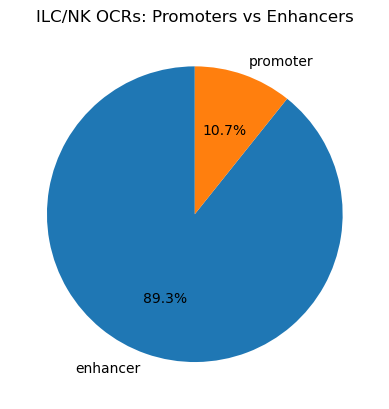

In [32]:
import matplotlib.pyplot as plt

annotated["annotation"].value_counts().plot.pie(autopct="%1.1f%%", startangle=90)
plt.title("ILC/NK OCRs: Promoters vs Enhancers")
plt.ylabel("")
plt.show()
